In [1]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report


In [ ]:


# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# Define paths
base_save_folder = 'captured_images'
gesture_labels = ['forward', 'backward', 'left', 'right', 'stop']

data = []

# Extract landmarks and labels
for label in gesture_labels:
    label_folder = os.path.join(base_save_folder, label)
    if not os.path.exists(label_folder):
        print(f"Folder {label_folder} does not exist.")
        continue
    for img_name in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_name)
        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to load image {img_path}.")
                continue
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = hands.process(image_rgb)
            
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    landmarks = []
                    for lm in hand_landmarks.landmark:
                        landmarks.extend([lm.x, lm.y, lm.z])
                    data.append([landmarks, label])
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")




In [131]:
# Convert to DataFrame
df = pd.DataFrame(data, columns=['landmarks', 'label'])

# Save to CSV
df.to_csv('hand_gesture_data.csv', index=False)

print(f"Total images processed: {len(data)}")

Total images processed: 1633


In [3]:
df = pd.read_csv("hand_gesture_landmarks1.csv")

In [4]:
df

,landmarks,label
0,"[0.6514360308647156, 0.7296967506408691, 3.693...",forward
1,"[0.6513686776161194, 0.7270573377609253, 3.630...",forward
2,"[0.6510484218597412, 0.7225046753883362, 3.660...",forward
3,"[0.6514084935188293, 0.7245794534683228, 3.802...",forward
4,"[0.6400588154792786, 0.7261943817138672, 3.692...",forward
...,...,...
3395,"[0.5781348943710327, 0.767610490322113, -4.528...",stop
3396,"[0.5806317925453186, 0.7588892579078674, -4.41...",stop
3397,"[0.599373459815979, 0.7493760585784912, -4.167...",stop
3398,"[0.6020784378051758, 0.7419999241828918, -4.04...",stop


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [6]:
from ast import literal_eval

# Convert the landmarks from string to list of floats
df['landmarks'] = df['landmarks'].apply(literal_eval)

# Verify the conversion
print(df['landmarks'].iloc[0])
print(type(df['landmarks'].iloc[0]))

# Convert the landmarks column to a list of lists
landmarks_list = df['landmarks'].tolist()

# Now convert this to a 2D numpy array
X = np.array(landmarks_list)
print(f"Shape of X after conversion: {X.shape}")

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['label'])
y = to_categorical(y)
print(f"Shape of y after encoding: {y.shape}")


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



[0.6514360308647156, 0.7296967506408691, 3.69301545788403e-07, 0.5992733836174011, 0.6804220080375671, -0.017948847264051437, 0.5818455815315247, 0.5970817804336548, -0.024646297097206116, 0.6095921397209167, 0.524261474609375, -0.034534163773059845, 0.6420678496360779, 0.48057571053504944, -0.043014030903577805, 0.5957925319671631, 0.508080244064331, 0.002942462218925357, 0.575634241104126, 0.42940178513526917, -0.010379997082054615, 0.5638284087181091, 0.38103070855140686, -0.0231260247528553, 0.5571965575218201, 0.33830755949020386, -0.03351406380534172, 0.6347363591194153, 0.49522390961647034, -0.0023376639001071453, 0.6350044012069702, 0.3971249461174011, -0.01657639630138874, 0.6318291425704956, 0.33595144748687744, -0.03216048330068588, 0.6342886686325073, 0.2885732054710388, -0.044158514589071274, 0.6690304279327393, 0.5078126788139343, -0.011696843430399895, 0.6772428750991821, 0.42252781987190247, -0.03348509594798088, 0.6655626893043518, 0.4510437250137329, -0.04183034226298

In [7]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])



c:\Users\graha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))




Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3217 - loss: 1.5355 - val_accuracy: 0.5221 - val_loss: 1.0765
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6809 - loss: 0.9440 - val_accuracy: 0.8397 - val_loss: 0.4584
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8882 - loss: 0.4432 - val_accuracy: 0.9926 - val_loss: 0.2305
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9349 - loss: 0.2580 - val_accuracy: 0.9956 - val_loss: 0.1355
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9644 - loss: 0.1725 - val_accuracy: 0.9971 - val_loss: 0.0841
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9761 - loss: 0.1130 - val_accuracy: 0.9985 - val_loss: 0.0399
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9905 - loss: 0.0690 - val_accuracy: 0.9985 - val_loss: 0.0307
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9908 - loss: 0.0588 - val_accuracy: 0.9985 - val_loss

In [9]:

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_test is in the correct format (not one-hot encoded)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
report = classification_report(y_test, y_pred_classes, target_names=le.classes_)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Classification Report:")
print(report)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Classification Report:
              precision    recall  f1-score   support

    backward       1.00      1.00      1.00       165
     forward       1.00      1.00      1.00       104
        left       1.00      1.00      1.00       120
       right       1.00      1.00      1.00       110
        stop       1.00      1.00      1.00       181

    accuracy                           1.00       680
   macro avg       1.00      1.00      1.00       680
weighted avg       1.00      1.00      1.00       680



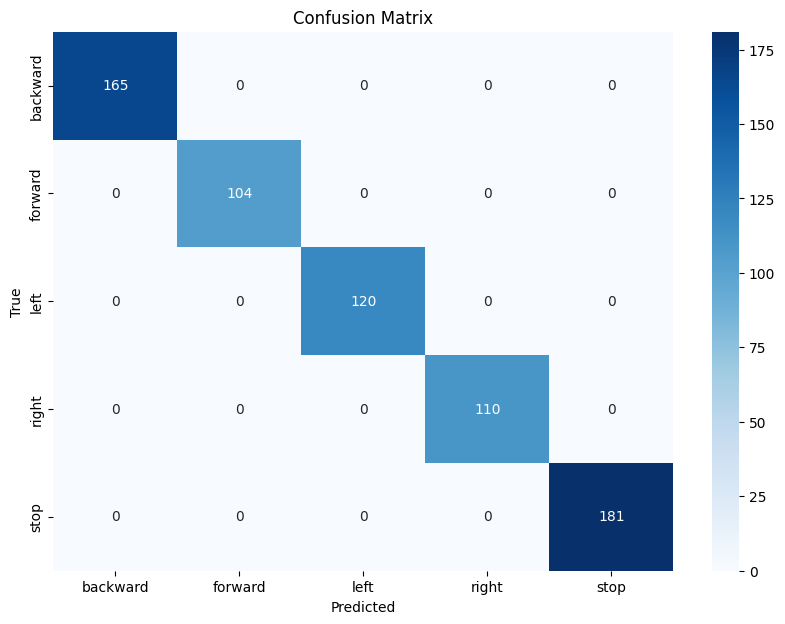

In [11]:


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


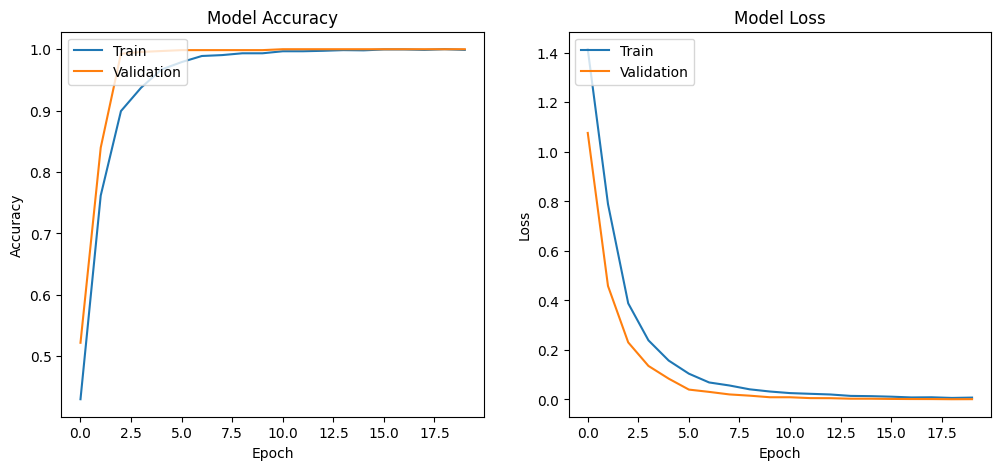

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [13]:
# Save the model
model.save('C:/Users/graha/OneDrive/Documents/Dissertation/Dataset/hand_gesture_model.h5')

In [154]:
# Save the label encoder classes
np.save('C:/Users/graha/OneDrive/Documents/Dissertation/Dataset/classes.npy', le.classes_, allow_pickle=True)